# Import Libraries

In [1]:
# Import essential libraries
import pandas as pd  
import numpy as np  
import seaborn as sns  
import matplotlib.pyplot as plt  
import re  
import joblib
import xgboost as xgb 
from scipy.sparse import hstack
from wordcloud import WordCloud  

# Preprocessing & Feature Engineering  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.preprocessing import LabelEncoder  

# Model Training & Evaluation  
from sklearn.model_selection import RandomizedSearchCV, train_test_split    
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve 
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# Load Dataset

In [2]:
# Define dataset path
file_path = r"C:\Users\linda\Downloads\fake_job_postings.csv"

# Load dataset  
df = pd.read_csv(file_path)  

# Display first few rows  
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Data Cleaning

In [3]:
# Check missing values
print(df.isnull().sum())

# Drop columns with excessive missing values
df.drop(["salary_range", "department"], axis=1, inplace=True)  

# Fill missing values with "Unknown"
df.fillna("Unknown", inplace=True)

# Convert categorical binary features into integers
df["telecommuting"] = df["telecommuting"].astype(int)  
df["has_company_logo"] = df["has_company_logo"].astype(int)  
df["has_questions"] = df["has_questions"].astype(int)  

# Remove duplicates
df.drop_duplicates(inplace=True)

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


# Exploratory Data Analysis (EDA)

* Fraudulent Job Posting Distribution

C:\Users\linda\AppData\Local\Temp\ipykernel_20020\4129138710.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["fraudulent"], palette="coolwarm")


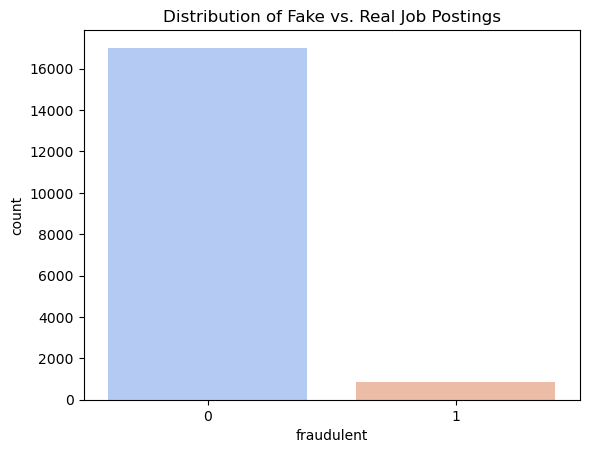

In [4]:
# Plot distribution of fraudulent jobs
sns.countplot(x=df["fraudulent"], palette="coolwarm")  
plt.title("Distribution of Fake vs. Real Job Postings")  
plt.show()

* Word Cloud for Fake Job Postings

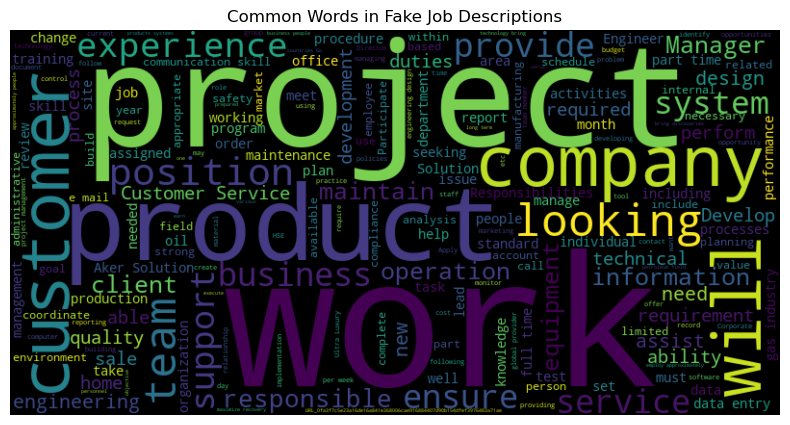

In [5]:
# Generate word cloud for fake job descriptions
fake_jobs = " ".join(df[df["fraudulent"] == 1]["description"])  
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(fake_jobs)  

plt.figure(figsize=(10,5))  
plt.imshow(wordcloud, interpolation="bilinear")  
plt.axis("off")  
plt.title("Common Words in Fake Job Descriptions")  
plt.show()

# Feature Engineering

In [6]:
# Assume 'df' is your dataset and 'description' is the text column
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = vectorizer.fit_transform(df["description"])  

# Extra Features (if any)
extra_features = df[["telecommuting", "has_company_logo", "has_questions"]].values

# Combine TF-IDF with additional features
X = hstack((X_tfidf, extra_features))  
y = df["fraudulent"]  

print("✅ Step 1: Feature Engineering Completed!")


✅ Step 1: Feature Engineering Completed!


* (2) Combine Features

#  Train Model

* (1) Train-Test Split

In [7]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (16092, 5003), Test set size: (1788, 5003)


In [8]:
# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Data balanced! New training size: {X_train_resampled.shape[0]}")

Data balanced! New training size: 30626


In [11]:
# Train Logistic Regression with class_weight='balanced'
log_reg_balanced = LogisticRegression(class_weight='balanced', random_state=42)

# Fit the model
log_reg_balanced.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_balanced = log_reg_balanced.predict(X_test)

In [12]:
# Initialize SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Logistic Regression with the SMOTE balanced data
log_reg_smote = LogisticRegression(random_state=42)
log_reg_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_smote = log_reg_smote.predict(X_test)

# Evaluation

Logistic Regression with SMOTE Accuracy: 0.9485

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      1701
           1       0.48      0.83      0.61        87

    accuracy                           0.95      1788
   macro avg       0.74      0.89      0.79      1788
weighted avg       0.97      0.95      0.95      1788



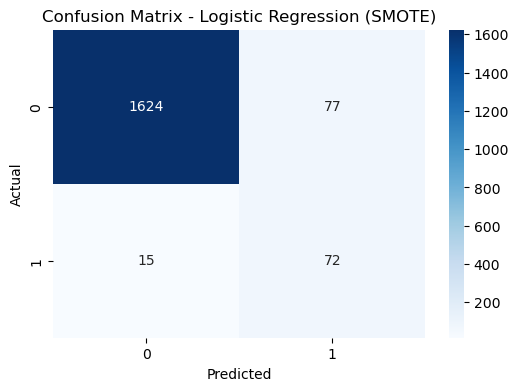

In [15]:
# Evaluation for Logistic Regression with SMOTE
print(f"Logistic Regression with SMOTE Accuracy: {accuracy_score(y_test, y_pred_smote):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))

# Confusion Matrix for SMOTE Model
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_smote), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression (SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Save the model
joblib.dump(logreg, "logreg_model.pkl")
print("Model saved as 'logreg_model.pkl'")

Number of feature names: 5000
Number of coefficients: 5003


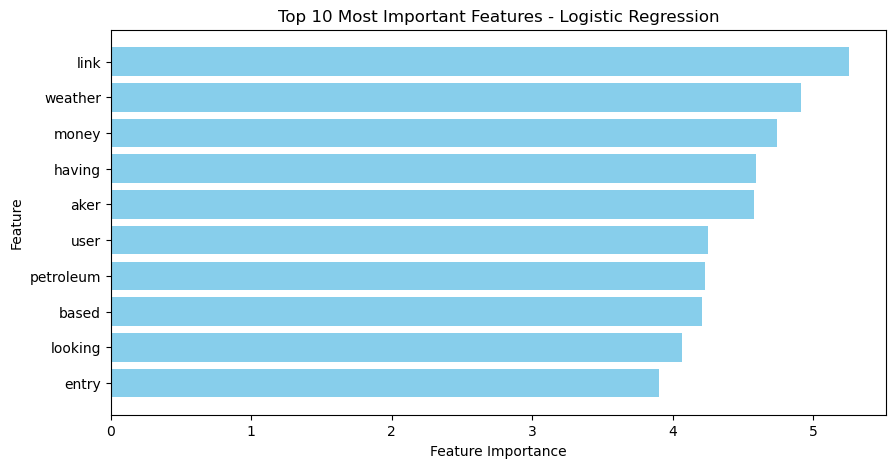

In [18]:
#####
# Feature Importance using Logistic Regression Coefficients
# Get the coefficients from the Logistic Regression model
coefficients = log_reg_balanced.coef_[0]  # Extracting coefficients for the features

# Get feature names from the TfidfVectorizer (assuming vectorizer is already defined)
feature_names = vectorizer.get_feature_names_out()

# Check lengths of feature_names and coefficients
print(f"Number of feature names: {len(feature_names)}")
print(f"Number of coefficients: {len(coefficients)}")

# Ensure both arrays have the same length
if len(feature_names) != len(coefficients):
    # Adjust the length to be the minimum of the two
    min_length = min(len(feature_names), len(coefficients))
    feature_names = feature_names[:min_length]
    coefficients = coefficients[:min_length]

# Combine the coefficients and feature names into a DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})

# Sort by importance (magnitude of coefficients)
feat_imp_df['Importance'] = feat_imp_df['Importance'].abs()  # Use absolute value for magnitude
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 5))
plt.barh(feat_imp_df['Feature'][:10], feat_imp_df['Importance'][:10], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features - Logistic Regression")
plt.gca().invert_yaxis()
plt.show()